#Housing Price Estimate

## Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

### Dataset is from kaggle: https://www.kaggle.com/competitions/home-data-for-ml-course/overview

In [2]:
train = pd.read_csv('train.csv')

In [3]:
print(train.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

In [4]:
test = pd.read_csv('test.csv')

In [5]:
print(test.head())

     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0    NaN  MnPrv         NaN   
1         Lvl    AllPub  ...           0        0    NaN    NaN        Gar2   
2         Lvl    AllPub  ...           0        0    NaN  MnPrv         NaN   
3         Lvl    AllPub  ...           0        0    NaN    NaN         NaN   
4         HLS    AllPub  ...         144        0    NaN    NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  
0       0      6

In [6]:
submission = pd.read_csv('sample_submission.csv')

In [7]:
print(submission.head())

     Id      SalePrice
0  1461  169277.052498
1  1462  187758.393989
2  1463  183583.683570
3  1464  179317.477511
4  1465  150730.079977


## Preprocessing!

### Let's combine Train/Test for Uniform Preprocessing

In [8]:
train['is_train'] = 1
test['is_train'] = 0
test['SalePrice'] = np.nan  # add dummy target

full = pd.concat([train, test], sort=False)


In [9]:
# Fill categorical NAs with "None"
categorical_fill_none = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                         'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                         'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']

for col in categorical_fill_none:
    full[col] = full[col].fillna("None")

# Fill numerical NAs with 0 or median
numerical_fill_zero = ['GarageYrBlt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                       'TotalBsmtSF', 'GarageCars', 'GarageArea']

for col in numerical_fill_zero:
    full[col] = full[col].fillna(0)

# Fill LotFrontage by median in each neighborhood
full['LotFrontage'] = full.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Drop columns with too many NAs
full.drop(['Utilities'], axis=1, inplace=True)


### Feature Engineering

In [10]:
# Total square footage
full['TotalSF'] = full['TotalBsmtSF'] + full['1stFlrSF'] + full['2ndFlrSF']
full['TotalBathrooms'] = (full['FullBath'] + (0.5 * full['HalfBath']) +
                          full['BsmtFullBath'] + (0.5 * full['BsmtHalfBath']))
full['Age'] = full['YrSold'] - full['YearBuilt']
full['Remodeled'] = (full['YearRemodAdd'] != full['YearBuilt']).astype(int)

### Encoding

In [11]:
# Label encode ordinal features
label_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
              'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
for col in label_cols:
    le = LabelEncoder()
    full[col] = le.fit_transform(full[col])

# One-hot encode nominal features
full = pd.get_dummies(full)

### Split Train/Test Back

In [12]:
train = full[full['is_train'] == 1].drop(['is_train'], axis=1)
test = full[full['is_train'] == 0].drop(['is_train', 'SalePrice'], axis=1)

X = train.drop(['SalePrice', 'Id'], axis=1)
y = train['SalePrice']


### 😨 NAN Values!!! This is an error fix I found training the models the first time

In [13]:
# Find columns with missing values
missing_cols = test.columns[test.isnull().any()]
print(test[missing_cols].isnull().sum())


BsmtFullBath      2
BsmtHalfBath      2
TotalBathrooms    2
dtype: int64


In [14]:
# Fill any remaining NaNs with median (usually a safe default)
test.fillna(test.median(numeric_only=True), inplace=True)


In [15]:
missing_cols = test.columns[test.isnull().any()]
print(test[missing_cols].isnull().sum())

Series([], dtype: float64)


## Model Time

In [16]:
# Define cross-validation
def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

# Ridge Regression
ridge = Ridge(alpha=20)
print("Ridge RMSLE:", rmsle_cv(ridge).mean())

# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3)
print("XGBoost RMSLE:", rmsle_cv(xgb_model).mean())


Ridge RMSLE: 33678.90034536739
XGBoost RMSLE: 28203.59239985275


In [17]:
xgb_model.fit(X, y)
ridge.fit(X, y)

# Predict
xgb_preds = xgb_model.predict(test.drop('Id', axis=1))
ridge_preds = ridge.predict(test.drop('Id', axis=1))

# Blend predictions
final_preds = (xgb_preds * 0.7) + (ridge_preds * 0.3)

In [18]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse

print("Ridge CV RMSE: {:.4f}".format(rmse_cv(ridge).mean()))
print("XGBoost CV RMSE: {:.4f}".format(rmse_cv(xgb_model).mean()))


Ridge CV RMSE: 33678.9003
XGBoost CV RMSE: 28203.5924


Both models off by around $30000 per prediction...not too bad without tuning

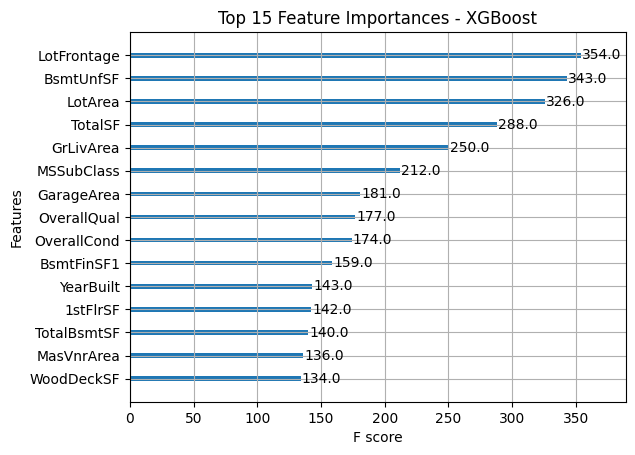

In [19]:
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title("Top 15 Feature Importances - XGBoost")
plt.show()

In [20]:
y_log = np.log1p(y)

def rmse_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    return np.sqrt(-cross_val_score(model, X, y_log, scoring="neg_mean_squared_error", cv=kf))

# Train models with y_log
xgb_model.fit(X, y_log)
ridge.fit(X, y_log)

# Predict and inverse transform
xgb_preds = np.expm1(xgb_model.predict(test.drop('Id', axis=1)))
ridge_preds = np.expm1(ridge.predict(test.drop('Id', axis=1)))
final_preds = 0.7 * xgb_preds + 0.3 * ridge_preds

In [21]:
print("Ridge log-RMSE: {:.4f}".format(rmse_cv(ridge).mean()))
print("XGBoost log-RMSE: {:.4f}".format(rmse_cv(xgb_model).mean()))


Ridge log-RMSE: 0.1476
XGBoost log-RMSE: 0.1310


## Improving Accuracy???

### Trying LightGBM

In [22]:
"""## Improving Accuracy Further"""

# LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, random_state=42)
print("LightGBM log-RMSE: {:.4f}".format(rmse_cv(lgb_model).mean()))

# Train and predict
lgb_model.fit(X, y_log)
lgb_preds = np.expm1(lgb_model.predict(test.drop('Id', axis=1)))

# Compare model performance
print("\nModel Comparison (log-RMSE):")
print(f" - Ridge     : {rmse_cv(ridge).mean():.4f}")
print(f" - XGBoost   : {rmse_cv(xgb_model).mean():.4f}")
print(f" - LightGBM  : {rmse_cv(lgb_model).mean():.4f}")

# Blend predictions
final_preds_blended = (xgb_preds * 0.5) + (ridge_preds * 0.2) + (lgb_preds * 0.3)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [23]:
# Compare model performance
print("\nModel Comparison (log-RMSE):")
print(f" - Ridge     : {rmse_cv(ridge).mean():.4f}")
print(f" - XGBoost   : {rmse_cv(xgb_model).mean():.4f}")
print(f" - LightGBM  : {rmse_cv(lgb_model).mean():.4f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

### XGBoost Tuning

In [28]:
y_log = np.log1p(y)

def rmsle_cv(model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    return np.sqrt(-cross_val_score(model, X, y_log, scoring="neg_mean_squared_error", cv=kf))

xgb_model = xgb.XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=4,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

print("XGBoost (Tuned) log-RMSE: {:.4f}".format(rmsle_cv(xgb_model).mean()))

# Fit and predict
xgb_model.fit(X, y_log)
xgb_preds = np.expm1(xgb_model.predict(test.drop('Id', axis=1)))

XGBoost (Tuned) log-RMSE: 0.1248
